# Tải thư viện 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
from tqdm import tqdm

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

# Tiền xử lí dữ liệu

## Phân tích dữ liệu

### Tập huấn luyện 

Đây là một trong những bộ dữ liệu lớn nhất..

In [2]:
Path('data/train.csv').stat().st_size

9555558244

In [3]:
train = pd.read_csv('data/train.csv', nrows=6000000)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 91.6 MB


In [5]:
train = pd.read_csv('data/train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 
                                                                                 'time_to_ failure': np.float64})

In [6]:
#check null
print(train.acoustic_data.isnull().values.any())
print(train.time_to_failure.isnull().values.any())

False
False


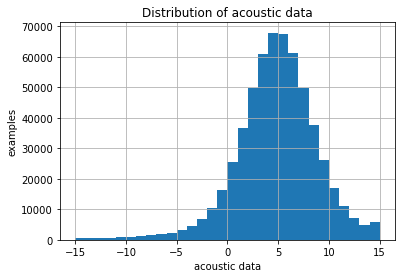

In [7]:
#Acoustic data distribution
# train_sample = train.sample(frac=0.1) 
# plt.figure(figsize=(10,5)) 
# plt.title("Acoustic data distribution") 
# ax = sns.distplot(train_sample.acoustic_data)

train_sample = train.sample(frac=0.1)
train_sample['acoustic_data'].hist(bins=30, range = [-15,15], align='mid')
plt.title("Distribution of acoustic data")
plt.xlabel('acoustic data')
plt.ylabel('examples')
plt.show()

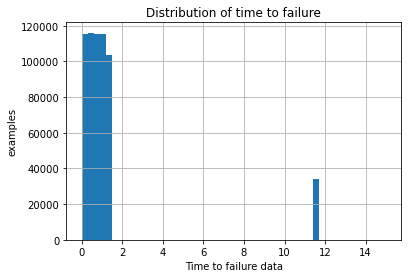

In [8]:
# plt.figure(figsize=(10,5)) 
# plt.title("Time to failure distribution") 
# ax = sns.kdeplot(train_sample.time_to_failure)

train_sample['time_to_failure'].hist(bins=50, range = [0,15], align='mid')
plt.title("Distribution of time to failure")
plt.xlabel('Time to failure data')
plt.ylabel('examples')
plt.show()

del train_sample

In [9]:
len(train['acoustic_data'].values[::100])

60000

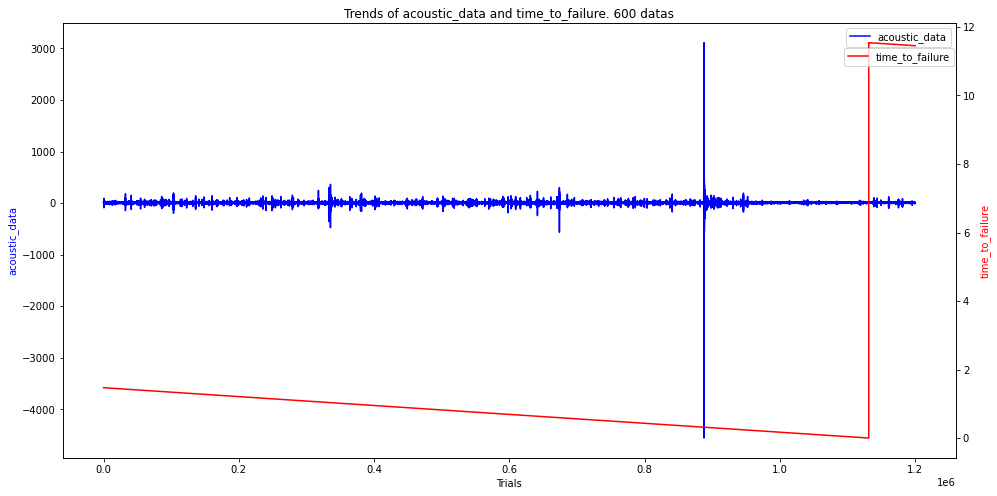

In [10]:
train_acoustic_data_small = train['acoustic_data'].values[::5]
train_time_to_failure_small = train['time_to_failure'].values[::5]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 600 datas")
plt.plot(train_acoustic_data_small, color='b')

ax1.set_ylabel('acoustic_data', color='b')
ax1.set_xlabel('Trials')
plt.legend(['acoustic_data'])

ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))

plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

### Tập kiểm tra

In [11]:
test1 = pd.read_csv('data/test/seg_00030f.csv') 
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   acoustic_data  150000 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


In [12]:
print(test1.describe())

       acoustic_data
count   150000.00000
mean         4.49178
std          4.89369
min        -75.00000
25%          2.00000
50%          4.00000
75%          7.00000
max        115.00000


In [13]:
test2 = pd.read_csv('data/test/seg_1dec9c.csv') 
test3 = pd.read_csv('data/test/seg_5cfba9.csv') 

In [14]:
test1.acoustic_data.shape

(150000,)

Text(0.5, 1.0, 'Distribution of acoustic data in test 1')

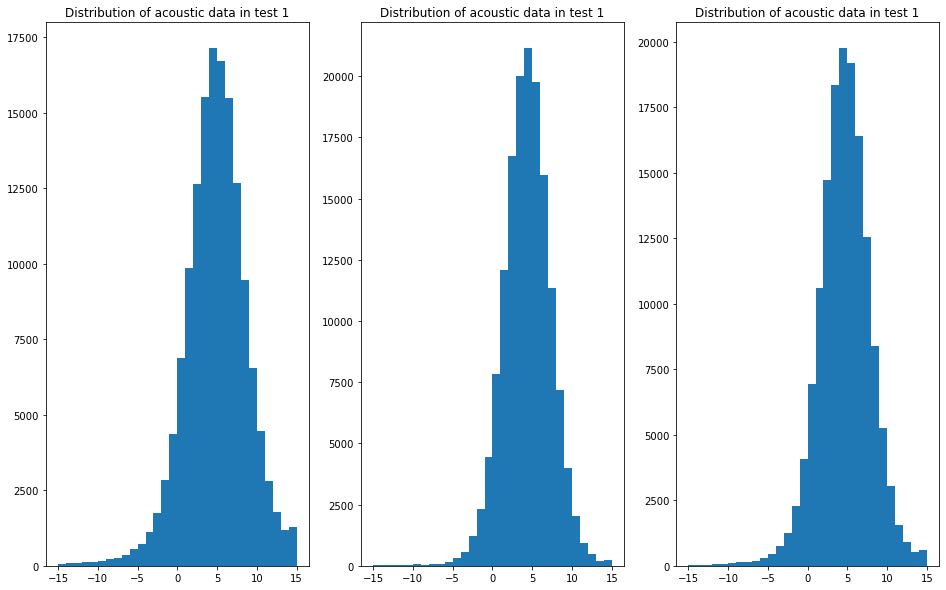

In [15]:
# plt.figure(figsize=(10,5)) 
# plt.title('Acoustic data distribution') 
# ax = sns.distplot(test1.acoustic_data, label='seg_37669c', kde=False)

f, axarr = plt.subplots(1, 3,figsize=(16,10))

axarr[0].hist(test1.acoustic_data, bins=30, range = [-15,15], align='mid')
axarr[0].set_title("Distribution of acoustic data in test 1")

axarr[1].hist(test2.acoustic_data, bins=30, range = [-15,15], align='mid')
axarr[1].set_title("Distribution of acoustic data in test 1")

axarr[2].hist(test3.acoustic_data, bins=30, range = [-15,15], align='mid')
axarr[2].set_title("Distribution of acoustic data in test 1")

Tương đối giống train. Có thể show thêm vài cái cho trựa quan

## Trích chọn đặc trưng 

In [16]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [17]:
def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [18]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [19]:
x = pd.Series(train['acoustic_data'].values)
change = (np.diff(x) / x[:-1]).values

In [20]:
rows = 150000
parts = int(60000000/rows)

X= pd.DataFrame(index=range(parts), dtype=np.float64)
Y= pd.DataFrame(index=range(parts), dtype=np.float64,columns=['time_to_failure']) 

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm(range(parts)): 
    data = pd.read_csv('data/train.csv', nrows = rows, skiprows=segment*rows+1)
    x = data.iloc[:,[0]].values
    x = pd.Series(x.reshape(len(x),))
    y = data.iloc[:,[1]].values[-1]
    
    Y.loc[segment, 'time_to_failure'] = y
    X.loc[segment, 'mean'] = x.mean()
    X.loc[segment, 'std'] = x.std()
    X.loc[segment, 'max'] = x.max()
    X.loc[segment, 'min'] = x.min()
    
    X.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X.loc[segment, 'abs_max'] = np.abs(x).max()
    X.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X.loc[segment, 'std_first_50000'] = x[:50000].std()
    X.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X.loc[segment, 'std_first_10000'] = x[:10000].std()
    X.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X.loc[segment, 'min_first_50000'] = x[:50000].min()
    X.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X.loc[segment, 'min_first_10000'] = x[:10000].min()
    X.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X.loc[segment, 'max_first_50000'] = x[:50000].max()
    X.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X.loc[segment, 'max_first_10000'] = x[:10000].max()
    X.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X.loc[segment, 'sum'] = x.sum()
    
    X.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X.loc[segment, 'trend'] = add_trend_feature(x)
    X.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X.loc[segment, 'mad'] = x.mad()
    X.loc[segment, 'kurt'] = x.kurtosis()
    X.loc[segment, 'skew'] = x.skew()
    X.loc[segment, 'med'] = x.median()
    
    X.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X.loc[segment,'MA_700MA_BB_high_mean'] = (X.loc[segment, 'Moving_average_700_mean'] + no_of_std * X.loc[segment, 'MA_700MA_std_mean']).mean()
    X.loc[segment,'MA_700MA_BB_low_mean'] = (X.loc[segment, 'Moving_average_700_mean'] - no_of_std * X.loc[segment, 'MA_700MA_std_mean']).mean()
    X.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X.loc[segment,'MA_400MA_BB_high_mean'] = (X.loc[segment, 'Moving_average_700_mean'] + no_of_std * X.loc[segment, 'MA_400MA_std_mean']).mean()
    X.loc[segment,'MA_400MA_BB_low_mean'] = (X.loc[segment, 'Moving_average_700_mean'] - no_of_std * X.loc[segment, 'MA_400MA_std_mean']).mean()
    X.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X.loc[segment, 'q999'] = np.quantile(x,0.999)
    X.loc[segment, 'q001'] = np.quantile(x,0.001)
    X.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        
        X.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        
        X.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

 77%|███████▋  | 307/400 [06:57<03:24,  2.20s/it]<ipython-input-20-47af8c73445e>:125: RuntimeWarning: divide by zero encountered in true_divide
  X.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
100%|██████████| 400/400 [11:12<00:00,  1.68s/it]


In [21]:
X.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,4.884067,5.101073,104.0,-98.0,-0.000007,0.036142,104.0,0.0,6.488500,3.664645,...,4.883417,0.295714,5.629,3.896,4.072,4.379,5.338,5.484,-0.000002,5.629
1,4.725767,6.588824,181.0,-154.0,-0.000007,0.022627,181.0,0.0,7.305475,5.493038,...,4.724874,0.231586,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002,5.667
2,4.906393,6.967397,140.0,-106.0,0.000000,0.023749,140.0,0.0,6.104859,8.603691,...,4.905841,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,0.000001,5.957
3,4.902287,6.922329,197.0,-199.0,0.000113,0.042489,199.0,0.0,6.238133,5.652526,...,4.901484,0.266699,5.858,3.722,4.304,4.433,5.317,5.453,-0.000003,5.858
4,4.908733,7.301125,145.0,-126.0,0.000053,0.038665,145.0,0.0,5.323750,7.694596,...,4.910197,0.228004,6.078,3.918,4.434,4.543,5.306,5.491,0.000002,6.078


In [22]:
Y.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


In [23]:
X.to_csv('input')

# Modeling

## Hướng tiếp cận machine learning

In [35]:
#Chuẩn hóa 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler.fit(X) 
X = scaler.transform(X)

In [36]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,1.893342,-0.122717,-0.178456,0.146459,-0.107710,0.127100,-0.178649,0.0,0.150589,-0.177160,...,1.889781,0.276421,0.014685,0.156604,0.319657,1.129618,1.922394,0.963557,-0.637460,0.014685
1,1.073345,0.024569,0.108700,-0.037106,-0.107710,-0.211447,0.061263,0.0,0.303234,-0.027823,...,1.068989,-0.155102,0.028331,-0.013207,0.689700,0.987316,0.661192,0.312657,-0.941640,0.028331
2,2.008995,0.062047,-0.044202,0.120235,0.001640,-0.183342,-0.066482,0.0,0.078909,0.226246,...,2.005873,0.083281,0.132471,0.212389,0.703491,1.410037,1.950215,0.968545,0.473455,0.132471
3,1.987722,0.057585,0.168369,-0.184614,1.860593,0.286085,0.117347,0.0,0.103810,-0.014796,...,1.983316,0.081176,0.096920,0.095556,0.852887,1.355628,1.825022,0.886247,-0.983960,0.096920
4,2.021116,0.095086,-0.025555,0.054676,0.876442,0.190298,-0.050903,0.0,-0.067035,0.151994,...,2.028427,-0.179210,0.175922,0.164323,1.151680,1.816017,1.774017,0.981014,0.711508,0.175922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.883860,-0.177771,-0.182186,0.162849,-0.217060,0.947422,-0.181765,0.0,-0.315340,-0.031247,...,0.878941,-0.177153,-0.053185,0.184321,0.510424,0.719453,0.554546,0.220383,1.052718,-0.053185
396,1.396924,-0.226224,-0.170998,0.244798,0.001640,1.156349,-0.172418,0.0,-0.443310,-0.066392,...,1.391674,-0.285776,-0.074372,0.120116,0.800024,1.250994,0.855937,0.302681,0.071409,-0.074372
397,1.566103,-0.255250,-0.372380,0.326747,-0.107710,1.304979,-0.340668,0.0,-0.342184,-0.178955,...,1.569025,0.379612,-0.028048,0.124326,0.227720,1.058467,1.829659,0.801455,-0.724747,-0.028048
398,1.325923,-0.214965,-0.178456,0.143181,0.767092,1.266329,-0.178649,0.0,-0.291797,-0.156422,...,1.325452,-0.295835,-0.072217,0.284664,0.928734,1.405852,0.976493,0.340089,0.063474,-0.072217


In [37]:
#train_test_split
from sklearn.model_selection import train_test_split

In [38]:
Y = Y.values.reshape((1,len(Y.values)))[0]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [40]:
result = pd.DataFrame()
result['actually'] = y_test

### Mô hình SVR

In [30]:
#SVR 
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import NuSVR, SVR 
from sklearn.metrics import mean_absolute_error 

In [83]:
params = {
    'kernel': [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’],
    'degree': [1,3,5]
    'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1], 
    'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]
}
gridSVR = GridSearchCV(SVR(), params, scoring='neg_mean_absolute_error')

In [84]:
gridSVR.fit(X_train, y_train)
print(gridSVR.best_params_)

{'C': 2, 'gamma': 0.01}


In [85]:
y_predict = gridSVR.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

1.6750650110329564


In [87]:
result['svr_predict']= y_predict
result['svr_mae'] = abs(y_predict-y_test)

### Mô hình Xgb

In [60]:
# Extreme Gradient Boosting
import xgboost as xgb 

In [73]:
# params = {
#     'n_estimators': [5, 10, 50], 
#      'max_depth': [1, 5, 10]
# }

params = {'eta': [0.03],
          'max_depth': [9],
          'subsample': [0.85],
          'objective': ['reg:squarederror'],
          'eval_metric': ['mae'],
          'nthread': [4]}

gridXGB = GridSearchCV(xgb.XGBRegressor(), params, scoring='neg_mean_absolute_error')

In [74]:
gridXGB.fit(X_train, y_train)
print(gridXGB.best_params_)

{'eta': 0.03, 'eval_metric': 'mae', 'max_depth': 9, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.85}


In [77]:
y_predict = gridXGB.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

1.666155306237581


In [78]:
result['xgb_predict']= y_predict
result['xgb_mae'] = abs(y_predict-y_test)

### Mô hình lgb

In [41]:
#LGBMRegressor
import lightgbm as lgb 

In [45]:
# params = {
#     'n_estimators': [5, 10, 50], 
#      'max_depth': [1, 5, 10]
# }

params = {'num_leaves': [128],
          'min_data_in_leaf': [79],
          'objective': ['huber'],
          'max_depth': [-1],
          'learning_rate': [0.01],
          "boosting": ["gbdt"],
          "bagging_freq": [5],
          "bagging_fraction": [0.8126672064208567],
          "bagging_seed": [11],
          "metric": ['mae'],
          "verbosity": [-1],
          'reg_alpha': [0.1302650970728192],
          'reg_lambda': [0.3603427518866501]
         }

# params = {
#     'learning_rate': [0.005, 0.01,.1],
#     'n_estimators': [50,100,150],
#     'num_leaves': [4,6,7,8], # large num_leaves helps improve accuracy but might lead to over-fitting
#     'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
#     'objective' : ['mean_absolute_error'],
#     'max_bin':[127,255], # large max_bin helps improve accuracy but might slow down training progress
#     'colsample_bytree' : [.4,.6,.8],
#     'subsample' : [.4,.6,.7,.8],
#     'reg_alpha' : [0,.5,1],
#     'reg_lambda' : [0,.5,1],
#     }


gridLGB = GridSearchCV(lgb.LGBMRegressor(), params, scoring='neg_mean_absolute_error')
gridLGB.fit(X_train, y_train)
print(gridLGB.best_params_)

[LightGBM] [Warning] bagging_fraction is set=0.8126672064208567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126672064208567
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.8126672064208567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8126672064208567
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_f

'num_leaves': Số lá tối đa trong một câu 
'min_data_in_leaf': số lượng dữ liệu tối thiểu trong một lá. C Can be used to deal with over-fitting
'objective': 'huber',
'max_depth': giới hạn độ sâu tối đa cho mô hình cây
'learning_rate': tỉ lệ học (cần tra thêm)
"boosting": "gbdt",
"bagging_freq":  chọn ngẫu nhiên một phần dữ liệu mà không cần lấy mẫu lại,
"bagging_fraction":chọn ngẫu nhiên một phần dữ liệu mà không cần lấy mẫu lại
"bagging_seed": hạt giống ngẫu nhiên để đóng bao
"metric": 'mae',
"verbosity": Kiểm soát mức độ chi tiết của LightGBM
'reg_alpha':L1 regularization
'reg_lambda': 0.3603427518866501

In [46]:
y_predict = gridLGB.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

3.3828500114572693


In [47]:
result['lgb_predict']= y_predict
result['lgb_mae'] = abs(y_predict-y_test)

### Mô hình học sâu 

In [70]:
import keras
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import Sequential
from keras import optimizers

In [97]:
model = Sequential()
model.add(Dense(83 , input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(38,  kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh')

In [74]:
# input_dim = X_train.shape[1]
# activation = 'tanh'
# classes = 1 #the output labels
# model = Model(input_dim = input_dim, activation = activation, classes = classes)

In [98]:
filepath = "weights.hdf5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),                                   #Stop training if no improvement is seen in Validation loss after 10 attempts
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta=1.5e-5, patience=5, verbose=1, mode='min'),                    #Slow down Learning rate if Validation Loss is not Decreasing after 5 attempts
    ModelCheckpoint(filepath, save_best_only=True,  save_weights_only=False, monitor='val_loss', mode='min', verbose=1) #Best Model weights are saved in hdf5 file every epoch
]

In [99]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=callbacks, verbose=1)

Epoch 1/100
17/17 [==============================] - 4s 12ms/step - loss: 5.1898 - val_loss: 2.3068

Epoch 00001: val_loss improved from inf to 2.30681, saving model to weights.hdf5
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 1.9903 - val_loss: 1.5754

Epoch 00002: val_loss improved from 2.30681 to 1.57541, saving model to weights.hdf5
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 1.6214 - val_loss: 1.5339

Epoch 00003: val_loss improved from 1.57541 to 1.53394, saving model to weights.hdf5
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 1.5830 - val_loss: 1.5000

Epoch 00004: val_loss improved from 1.53394 to 1.50001, saving model to weights.hdf5
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 1.3363 - val_loss: 1.4579

Epoch 00005: val_loss improved from 1.50001 to 1.45791, saving model to weights.hdf5
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 1.327

In [80]:
result

,actually,xgb_predict,xgb_mae,lgb_predict,lgb_mae
0,4.827998,3.375349,1.452649,3.375349,1.452649
1,2.061598,1.147086,0.914512,1.147086,0.914512
2,0.144499,10.415483,10.270984,10.415483,10.270984
3,4.788700,5.171855,0.383156,5.171855,0.383156
4,9.347898,10.505568,1.157669,10.505568,1.157669
...,...,...,...,...,...
127,0.035796,11.205894,11.170097,11.205894,11.170097
128,6.464498,5.603946,0.860553,5.603946,0.860553
129,3.425696,1.757606,1.668090,1.757606,1.668090
130,0.853996,2.233560,1.379563,2.233560,1.379563


### Visualize result

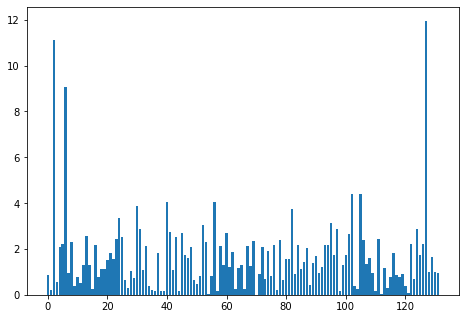

In [88]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(132),result['svr_mae'])
plt.show()

In [89]:
result

,actually,xgb_predict,xgb_mae,lgb_predict,lgb_mae,svr_predict,svr_mae
0,4.827998,3.375349,1.452649,3.375349,1.452649,3.973026,0.854972
1,2.061598,1.147086,0.914512,1.147086,0.914512,2.274904,0.213306
2,0.144499,10.415483,10.270984,10.415483,10.270984,11.257171,11.112671
3,4.788700,5.171855,0.383156,5.171855,0.383156,5.342692,0.553992
4,9.347898,10.505568,1.157669,10.505568,1.157669,11.419014,2.071116
...,...,...,...,...,...,...,...
127,0.035796,11.205894,11.170097,11.205894,11.170097,12.000912,11.965116
128,6.464498,5.603946,0.860553,5.603946,0.860553,5.457946,1.006552
129,3.425696,1.757606,1.668090,1.757606,1.668090,1.780344,1.645352
130,0.853996,2.233560,1.379563,2.233560,1.379563,1.863944,1.009947


### Save model

In [35]:
#save model
import pickle

In [36]:
filename = "SVRModel.pkl"
with open(filename, 'wb') as file:
    pickle.dump(gridSVR, file)

In [37]:
with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [38]:
y_predict = pickle_model.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict)
print(mae)

1.6750650110329564


In [39]:
y_predict

array([ 3.9730261 ,  2.27490354, 11.25717061,  5.34269167, 11.4190138 ,
       11.90622517,  9.20578282, 10.27076738,  4.93025737,  7.68285044,
        1.85367344, 12.56444552, 12.07947085, 12.70931947,  6.53169229,
       11.09665422,  4.31566437, 11.7469065 ,  5.07811993, 11.03413099,
       11.47036907,  2.66425009, 10.36154927,  4.84909243,  4.77309539,
        9.18622765,  7.8969526 ,  3.91086164,  1.74378964,  8.18882411,
        7.89308631,  2.59431636,  3.89722076, 12.8962652 ,  4.2971955 ,
        8.6615489 ,  8.40838406, 12.01496962,  6.63257673,  7.30388616,
        8.23880483, 13.55098932,  8.94979507,  2.98969444,  9.94455853,
        9.56162384,  5.45404622,  4.31369229,  2.67296145,  6.87530302,
       10.72804763,  1.28987662, 10.94685212, 12.56829954, 12.5944848 ,
       12.26084139,  8.31425515,  6.08656402,  2.38179469,  5.74424496,
        5.42638295,  2.73592542,  4.91006844, 10.19306821,  7.87175648,
        1.5090298 , 13.20047846,  4.65503399, 10.53928649, 12.48